In [1]:
import sys
import os
cwd = os.getcwd()
parent_dir = os.path.dirname(cwd)
parent_dir = os.path.dirname(parent_dir)
cwd = parent_dir
sys.path.append(parent_dir)
project_root = parent_dir
print(parent_dir)
import polyscope.imgui as psim
import scipy as sp
import numpy as np
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import jax.random as jrandom
import jax.nn as nn
import jax.lax as lax
import jax.random as jrandom
import jax.nn as nn
import jax.lax as lax
import os
import jax.experimental.sparse as jsp
from scipy.sparse import diags, csr_matrix
from src.dataGenerator.spherical_data_generator import *
from src.utils.sht_helper import *
from src.stochastics.sde import *
from src.stochastics.sde_solver import *
import matplotlib.pyplot as plt
import random
import src.training.trainer as Trainer
from flax.training import checkpoints
from src.models.neural_operator import CTShapeSFNO
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import open3d as o3d
def get_random_int():
    return random.randint(0, 1000000)

/home/zjc/PycharmProjects/ShapeSphericalFNO/ShapeSphericalFNO
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def heart_surface_parametric(u, v, scale=1):
    """
    Parametric equation for a heart surface
    """
    x = scale * (4 * np.sin(u) * np.sin(u) * np.sin(u)) * np.cos(v)
    z = scale * (-0.5 * np.sin(u) * np.cos(u) * np.cos(u)) * np.cos(v)
    y = scale * (4 * np.sin(u) * np.sin(u) * np.sin(u)) * np.sin(v) - 2 * np.cos(u) * np.cos(u)
    
    return x, y, z

def generate_heart_point_cloud(L=20):
    """
    Generate a heart-shaped point cloud with L, 2L-1, 3 structure
    L: Resolution parameter, higher value gives more points
    """
    # Calculate 2L-1 for the second dimension
    L2 = 2*L - 1
    
    # Initialize arrays to store point cloud coordinates
    points = np.zeros((L * L2, 3))
    
    # Generate points on the heart surface
    count = 0
    
    # Parameter ranges
    u_range = np.linspace(0, np.pi, L)
    v_range = np.linspace(-np.pi/2, np.pi/2, L2)
    
    for i, u in enumerate(u_range):
        for j, v in enumerate(v_range):
            x, y, z = heart_surface_parametric(u, v, scale=2)
            
            # Store the point
            points[count] = [x, y, z]
            count += 1
    
    return points

# mesh = o3d.io.read_triangle_mesh(os.path.join(cwd, "data/test_meshes/bunny.obj"))
# pcd_bunny = mesh.sample_points_poisson_disk(number_of_points=2556)
# numpy_bunny = np.asarray(pcd_bunny.points)
# # rescale the bunny to unit sphere
# numpy_bunny = numpy_bunny * 10 - (-0.2,1.0,0)
# L = 36
# numpy_bunny_gl = np.reshape(numpy_bunny, (L, 2*L-1, 3))

In [3]:
jax.clear_caches()
train_steps = 1000
retrain = False
retrain_steps = 1000
draw_unconditional = False
in_grid_L = 12
bump_sphere_data_generator_XT = S2ManifoldDataGenerator(A=0.15, n=2, m=3, radius=0.8, sampling="gl", manifold_type="bump_sphere", seed=get_random_int(), randomization=False)
sphere_data_generator_XT = S2ManifoldDataGenerator(radius=0.8, sampling="gl", manifold_type="sphere", seed=get_random_int(), randomization=False)
superquadric_sphere_data_generator_XT = S2ManifoldDataGenerator(epsilon1=0.7, epsilon2=0.5, a=0.8, sampling="gl", manifold_type="superquadric_sphere", seed=get_random_int(), randomization=False)
# sphere_data_generator_XT = S2ManifoldDataGenerator(a=0.4, b=0.5, c=0.8, epsilon1=0.5, epsilon2=0.83, radius=0.8, sampling="gl", manifold_type="superellipsoid", seed=get_random_int(), randomization=False)
# sphere_data_generator_XT = S2ManifoldDataGenerator(epsilon1=0.2, epsilon2=0.5, a=0.3, sampling="gl", manifold_type="superquadric_sphere", seed=get_random_int(), randomization=False)
# sphere_data_generator_XT = S2ManifoldDataGenerator(radius=0.8, sampling="gl", manifold_type="sphere", seed=get_random_int(), randomization=False)
xT = sphere_data_generator_XT.generate_data(in_grid_L, 1)
print(xT.shape)
sphere_data_generator_X0 = S2ManifoldDataGenerator(radius=0.5, sampling="gl", manifold_type="sphere", seed=get_random_int(), randomization=False)
x0 = sphere_data_generator_X0.generate_data(in_grid_L, 5)
print(x0.shape)
sde_3d = Kunita_Flow_SDE_3D_Eulerian_2Dmanifold_distance(k_alpha=1.6, k_sigma=0.4, grid_num=10, grid_range=[-1,1], x0=x0[0])
# sde_3d = Kunita_Flow_SDE_3D_Eulerian_2Dmanifold(k_alpha=1.6, k_sigma=0.4, grid_num=10, grid_range=[-1,1], x0=x0[0])
# sde_3d = Brownian_Motion_SDE_2D_Manifold(sigma=0.4, x0=x0[0])
sde_solver = EulerMaruyama.from_sde(sde_3d, 0.02, 1.0, 3, None,debug_mode=False)
xs,_ = sde_solver.solve(x0[0], rng_key=jrandom.PRNGKey(get_random_int()))


model = CTShapeSFNO(x_feature_dim=3, l_list=(8,8), lift_dim=16, latent_feature_dims=(2,2), sampling="gl", activation="gelu")
trainer = Trainer.NeuralOpTrainer(seed=get_random_int(), landmark_num=in_grid_L)

checkpoint_path = project_root + '/checkpoints/sphere_model'
restored_checkpoint = checkpoints.restore_checkpoint(checkpoint_path, target=None)
params = restored_checkpoint["model"]["params"]
train_state = trainer.train_state_init(model, lr=1e-4, model_kwargs={'x': jax.random.normal(jrandom.PRNGKey(get_random_int()), x0[0].shape), 't': jnp.array([0]),'object_fn': 'Yang', 'x_L': in_grid_L}, retrain=True, ckpt_params=params)
test_L = 40
score_fn = lambda x, t, x0: train_state.apply_fn(train_state.params, x, t, test_L)
x0 = sphere_data_generator_X0.generate_data(test_L, 5)
# xT = sphere_data_generator_XT.generate_data(test_L, 1)
# xT = jnp.array(numpy_bunny_gl)
xT_superquadric = superquadric_sphere_data_generator_XT.generate_data(test_L, 1)
xT_bump_sphere = bump_sphere_data_generator_XT.generate_data(test_L, 1)
xT_sphere = sphere_data_generator_XT.generate_data(test_L, 1)

sde_3d = Kunita_Flow_SDE_3D_Eulerian_2Dmanifold_distance(k_alpha=1.6, k_sigma=0.4, grid_num=10, grid_range=[-1,1], x0=x0[0])
# sde_3d = Brownian_Motion_SDE_2D_Manifold(sigma=0.4, x0=x0[0])
reverse_sde = Time_Reversed_SDE_2Dmanifold_Yang(sde_3d, score_fn, 1.0,0.02)
reverse_solver = EulerMaruyama.from_sde(reverse_sde, 0.02, 1.0, 3, condition_x=x0[0],debug_mode=False)
condition_xs_sphere,_ = reverse_solver.solve(xT_sphere[0] - x0[0], rng_key=jrandom.PRNGKey(get_random_int()))
condition_xs_superquadric,_ = reverse_solver.solve(xT_superquadric[0] - x0[0], rng_key=jrandom.PRNGKey(get_random_int()))
condition_xs_bump_sphere,_ = reverse_solver.solve(xT_bump_sphere[0] - x0[0], rng_key=jrandom.PRNGKey(get_random_int()))
time_steps = 50
time_lst = np.linspace(0, 1, time_steps)
# score_lst = []
# score_lst = jax.vmap(score_fn, in_axes=(0, 0, None))(condition_xs[:-1], time_lst, x0[0])
# print("score_lst.shape", score_lst.shape)
condition_xs_sphere = condition_xs_sphere + x0[0]
condition_xs_superquadric = condition_xs_superquadric + x0[0]
condition_xs_bump_sphere = condition_xs_bump_sphere + x0[0]




(1, 12, 23, 3)
(5, 12, 23, 3)
(1000, 3)
(12, 23, 3)
(1000, 3)
(40, 79, 3)
score_fn: [[[-0.00286688 -0.00130911 -0.00685247]
  [-0.0027169  -0.00138093 -0.0068576 ]
  [-0.00256301 -0.00144156 -0.0068623 ]
  ...
  [-0.00328414 -0.00103144 -0.00683485]
  [-0.0031514  -0.00113381 -0.00684106]
  [-0.00301202 -0.00122657 -0.00684695]]

 [[-0.00386146 -0.00349012 -0.00686477]
  [-0.00351844 -0.00365441 -0.00687631]
  [-0.00316644 -0.00379305 -0.00688692]
  ...
  [-0.00481544 -0.00285455 -0.0068252 ]
  [-0.004512   -0.00308893 -0.00683914]
  [-0.00419334 -0.00330123 -0.00685235]]

 [[-0.00485953 -0.00565744 -0.00681981]
  [-0.0043248  -0.00591357 -0.00683747]
  [-0.00377595 -0.00612962 -0.00685375]
  ...
  [-0.00634615 -0.0046659  -0.00675945]
  [-0.00587337 -0.00503163 -0.00678069]
  [-0.0053768  -0.00536284 -0.00680084]]

 ...

 [[-0.00645627 -0.00377095  0.01103128]
  [-0.00590981 -0.00401944  0.01102801]
  [-0.00534746 -0.00422787  0.01102505]
  ...
  [-0.00796687 -0.00280197  0.01104282]


In [4]:
def plot_time_slice_shape(x0_eval, xT_eval, xts, ts=None):
    import matplotlib.pyplot as plt

    cmap = plt.get_cmap("autumn")
    num_shapes = xts.shape[0]
    fig, axs = plt.subplots(num_shapes, 6, subplot_kw={'projection': '3d'}, figsize=(10, 1.8 * num_shapes),
                            gridspec_kw={'wspace': -0.1, 'hspace': -0.1})
    # plt.subplots_adjust(wspace=0.01, hspace=0.01)

    # 时间点
    if ts is None:
        ts = [0.0] + [0.2 * j for j in range(1, 6)]  # 默认时间点
    
    for i in range(num_shapes):
        x0_eval_i = x0_eval[i]  
        xT_eval_i = xT_eval[i]
        xts_i = xts[i]

        axs[i, 0].plot_wireframe(x0_eval_i[:, :, 0], x0_eval_i[:, :, 1], x0_eval_i[:, :, 2], alpha=0.2, color="red",zorder=11)
        axs[i, 0].plot_wireframe(xT_eval_i[:, :, 0], xT_eval_i[:, :, 1], xT_eval_i[:, :, 2], alpha=0.1, color="cornflowerblue",zorder=10)
        axs[i, 0].plot_surface(xts_i[0][:, :, 0], xts_i[0][:, :, 1], xts_i[0][:, :, 2], alpha=0.7, cmap=cmap, antialiased=True, shade=True, rstride=1, cstride=1,zorder=0)
        axs[i, 0].set_box_aspect([5, 5, 5])
        axs[i, 0].set_position([0, 0, 1, 1], which='active')
        axs[i, 0].grid(False)
        axs[i, 0].set_axis_off()
        # only set the title for the first row
        if i == 0:
            axs[i, 0].set_title(f"t = {ts[0]:.2f}", pad=5)

        for j in range(1, 6):
            x = xts_i[j*10-1]
            # Remove margins around each 3D axis
            axs[i, j].margins(0, 0, 0)
            # Set the aspect ratio to be equal
            axs[i, j].set_box_aspect([5, 5, 5])
            # Remove padding inside each subplot
            axs[i, j].set_position([0, 0, 1, 1], which='active')
            axs[i, j].plot_wireframe(x0_eval_i[:, :, 0], x0_eval_i[:, :, 1], x0_eval_i[:, :, 2], alpha=0.2, color="red",zorder=11)
            axs[i, j].plot_surface(x[:, :, 0], x[:, :, 1], x[:, :, 2], alpha=0.7, cmap=cmap, antialiased=True, shade=True, rstride=1, cstride=1,zorder=0)
            axs[i, j].plot_wireframe(xT_eval_i[:, :, 0], xT_eval_i[:, :, 1], xT_eval_i[:, :, 2], alpha=0.1, color="cornflowerblue",zorder=10)
            axs[i,j].grid(False)
            axs[i, j].set_axis_off()
            axs[i, j].dist = 6
            axs[i, j].elev = 20
            axs[i, j].azim = -60
            # only set the title for the row
            if i == 0:
                axs[i, j].set_title(f"t = {ts[j]:.2f}", pad=5)

    # 构造 legend
    legend_elements = [
        Line2D([0], [0], color='red', lw=2, label=r'$s_0$'),
        Line2D([0], [0], color='blue', lw=2, label=r'$s_T$'),
        Patch(facecolor=cmap(0.5), edgecolor='k', label=r'$s_t$'),
    ]
        # More aggressive spacing adjustments
    plt.tight_layout(pad=0.0, h_pad=-0.5, w_pad=-0.5)
    
    # Now apply final adjustments - these override tight_layout
    plt.subplots_adjust(
        left=0.01,    # minimize left margin
        right=0.99,   # maximize right extent
        top=0.92,     # leave space for legend
        bottom=0.001,  # minimize bottom margin
        wspace=-1,  # negative space to force overlap
        hspace=-1   # negative space to force overlap
    )
    fig.legend(handles=legend_elements, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.05))
    # plt.tight_layout(pad=0.0)
    # plt.subplots_adjust(top=0.95)  # 给 legend 留空间
    plt.savefig("time_slice_shape_kunita_sphere.pdf", dpi=500, bbox_inches='tight')
    plt.show()

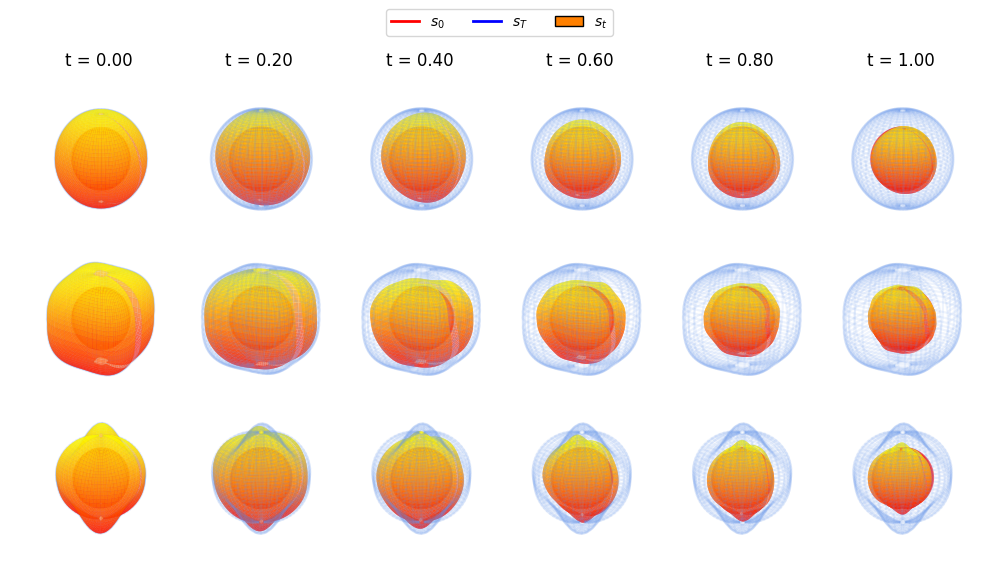

In [5]:

# plot_time_slice_shape(x0[0], xT[0], condition_xs)
x0s = jnp.stack([x0[0], x0[0], x0[0]], axis=0)
xTs = jnp.stack([xT_sphere[0], xT_superquadric[0], xT_bump_sphere[0]], axis=0)
condition_xs = jnp.stack([condition_xs_sphere, condition_xs_superquadric, condition_xs_bump_sphere], axis=0)
plot_time_slice_shape(x0s, xTs, condition_xs)

In [6]:
# draw the selected time slice and corresponding score function output


xs_sphere = xs

xs_sphere_score = jax.vmap(score_fn, in_axes=(0, 0, None))(xs_sphere[:-1], time_lst, x0[0])


In [7]:

# plot score field on the sphere, show quiver plot
def plot_score_field_on_sphere(score_field, x, title):
    # plot the score field on the sphere
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_axis_off()
    ax.grid(False)
    ax.elev = 20
    ax.azim = -60
    # ax.scatter(x[:,:, 0], x[:,:, 1], x[:,:, 2], alpha=1.0, color="yellow",zorder=12, marker="+",s= 50)
    ax.scatter(x[:,:, 0], x[:,:, 1], x[:,:, 2], alpha=0.5, color="red",zorder=10)
    ax.quiver(x[:, :, 0], x[:, :, 1], x[:, :, 2], score_field[:, :, 0], score_field[:, :, 1], score_field[:, :, 2],
              alpha=0.5, color="blue",zorder=10, length=0.4)
    plt.tight_layout()
    plt.savefig(f"score_field_on_sphere_{title}.png", dpi=300,transparent=True,bbox_inches="tight")

def plot_sphere(x, title):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_axis_off()
    ax.grid(False)
    ax.elev = 20
    ax.azim = -60
    # set
    ax.scatter(x[:,:, 0], x[:,:, 1], x[:,:, 2], alpha=0.5, color="red",zorder=11)
    plt.tight_layout()
    plt.savefig(f"sphere_{title}.png", dpi=300,transparent=True,bbox_inches="tight")

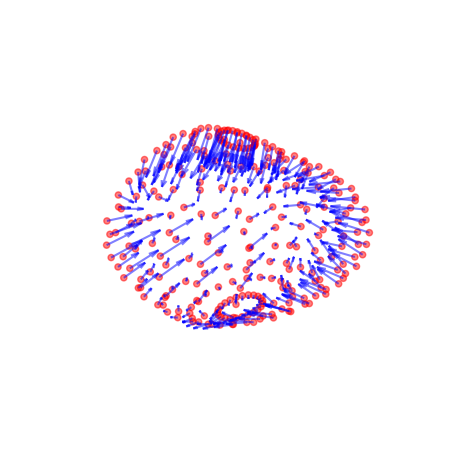

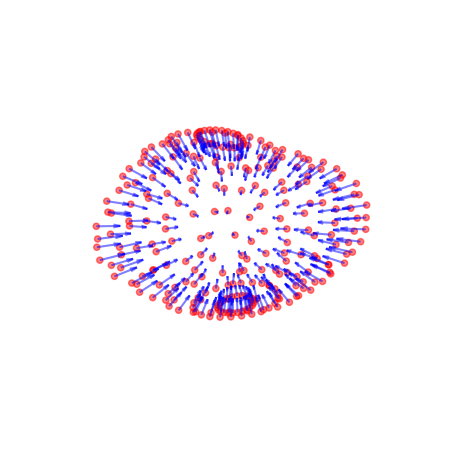

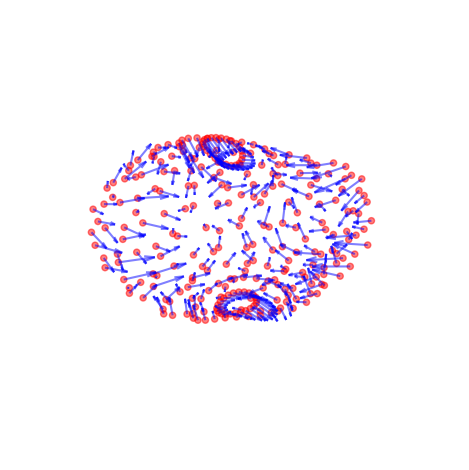

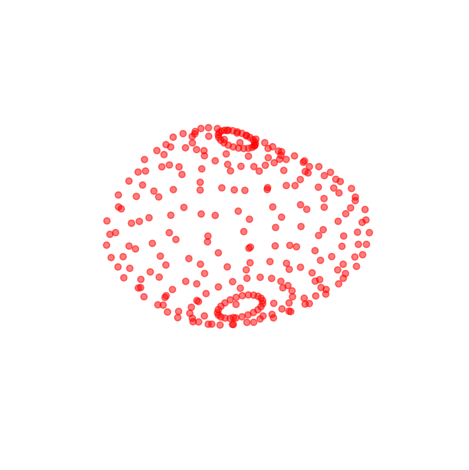

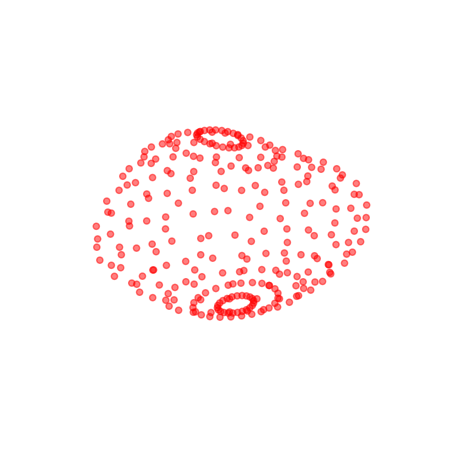

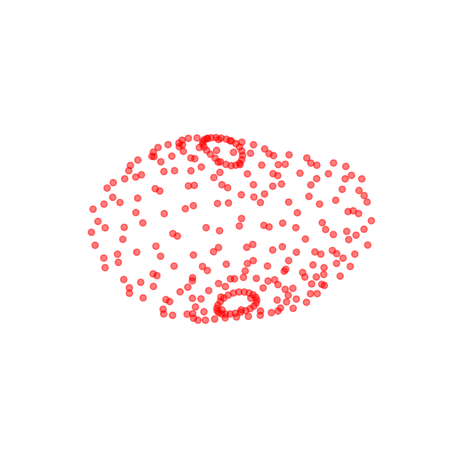

In [8]:


plot_score_field_on_sphere(xs_sphere_score[4], xs_sphere[14], "sphere_4")
plot_score_field_on_sphere(xs_sphere_score[22], xs_sphere[22], "sphere_22")
plot_score_field_on_sphere(xs_sphere_score[49], xs_sphere[45], "sphere_45")


plot_sphere(xs_sphere[14], "sphere_14")
plot_sphere(xs_sphere[22], "sphere_22")
plot_sphere(xs_sphere[45], "sphere_45")
